In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
companies = pd.read_csv("companies.txt", sep="\t", encoding = "ISO-8859-1")
rounds2 = pd.read_csv('rounds2.csv', sep=',', encoding = "ISO-8859-1")

Understand the data present in rounds2 file


In [3]:
rounds2.head()
rounds2.describe()

,raised_amount_usd
count,9.495900e+04
mean,1.042687e+07
std,1.148212e+08
min,0.000000e+00
25%,3.225000e+05
50%,1.680511e+06
75%,7.000000e+06
max,2.127194e+10


We need to do a data cleanup as the company permalink is in mixed case. The case is not consistent. We will convert it to lowercase.

In [4]:
rounds2.company_permalink = rounds2.company_permalink.astype(str).str.lower()
rounds2['company_permalink'].unique().size

66370

There are NaN values in raised_amount_usd. We need to drop these

In [5]:
rounds2.dropna(subset=['raised_amount_usd'], inplace=True)

In [6]:
# Get the unique company ids and their size
companies_in_rounds = rounds2["company_permalink"].unique()
companies_in_rounds.shape


(53915,)

Understand the data present in the companies file

In [7]:
companies.head()
companies.describe()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66102,61191,27296,4,137,311,1092,5111,3978
top,/Organization/Lexpertia-Com,Spire,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


Since we are going to merge with rounds2 later, we'll have the permalink in the same lowercase format.
We will do this datacleanup before further operations.

In [8]:
companies.permalink = companies.permalink.astype(str).str.lower()

Get the number of unique companies in the companies file

In [9]:
companies_in_companies = companies["permalink"].unique()
companies_in_companies.size

66368

Are there companies in rounds2 which are not there in companies?

In [10]:
set(companies_in_companies).issubset(set(companies_in_rounds))

False

How Many companies are common across both the files.

In [11]:
len(set(companies_in_companies).intersection(set(companies_in_rounds)))

53914

Merge the two data frames so that all  variables (columns)  in the companies frame are added to the rounds2 data frame. 

In [12]:
master_frame = pd.merge( rounds2, companies, left_on='company_permalink', right_on = 'permalink', how='left')

In [13]:
master_frame.shape[0]


94959

# -------------------- CHECKPOINT 2 BEGINS ---------------------------
Average funding amount of venture type

In [14]:
venture = master_frame.loc[master_frame['funding_round_type'] == "venture"]["raised_amount_usd"].mean()
print(venture)

11748949.129489528


Average funding amount of angel type

In [15]:
angel = master_frame.loc[master_frame['funding_round_type'] == 'angel']['raised_amount_usd'].mean()
print(angel)

958694.4697530865


Average funding amount of seed type

In [16]:
seed = master_frame.loc[master_frame['funding_round_type'] == 'seed']['raised_amount_usd'].mean()
print(seed)

719817.9969071728


Average funding amount of private equity type

In [17]:
private_equity = master_frame.loc[master_frame['funding_round_type'] == 'private_equity']['raised_amount_usd'].mean()
print(private_equity)

73308593.02944215


# ------------------------ CHECKPOINT 3 BEGINS -----------------

In [18]:
countries_by_venture_raised = master_frame.loc[master_frame['funding_round_type'] == 'venture'].groupby('country_code')['raised_amount_usd'].sum()

In [19]:
top9 = pd.DataFrame(countries_by_venture_raised.nlargest(9))

In [20]:
top_countries = top9.head(10)
print(top_countries)

              raised_amount_usd
country_code                   
USA                4.225108e+11
CHN                3.983542e+10
GBR                2.024563e+10
IND                1.439186e+10
CAN                9.583332e+09
FRA                7.259537e+09
ISR                6.907515e+09
DEU                6.346960e+09
JPN                3.363677e+09


# ------------------------ CHECKPOINT 4 BEGINS -----------------

Creating a lambda to get the sector for a given category

In [21]:
# Creating the right data structures - map from the mapping file

mapping_df = pd.read_csv('mapping.csv')

#Correcting the mapping file. replace 0 by na
mapping_df['category_list'] = mapping_df['category_list'].str.replace('0','na') 
mapping_df['category_list'] = mapping_df['category_list'].str.lower()
mapping_df.set_index('category_list', inplace=True)

dictionary = mapping_df.to_dict(orient='index')

#Function to lookup the data in mapping.csv and get the main sector for a given company
def getSector(category_list):
#    print(category_list)
    
    if(isinstance(category_list,float)):
        return "Others"
    
    category = category_list.split('|')[0]
#    print(category)
    
    sector_index = dictionary.get(category.lower())
    
    if(sector_index == None):
#        print("sector not found for " + category_list)
        return "Others"

    for k, v in sector_index.items():
        if(v == 1):
#            print(category_list + "--------" + k)
            return k

#Testing the get Sector Function
getSector('nan')

'Others'

In [22]:
#Gets the primary sector given the category list
def getPrimarySector(category_list):
    if(isinstance(category_list, float)):
        return "other"
    return category_list.split("|")[0]

master_frame['primary_sector'] = master_frame.apply(lambda row: getPrimarySector(row['category_list']), axis = 1)

In [23]:
master_frame['main_sector'] = master_frame.apply(lambda row: getSector(row['category_list']), axis=1)

In [24]:
master_frame.groupby('main_sector').count()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,primary_sector
main_sector,,,,,,,,,,,,,,,,,
Automotive & Sports,1941,1941,1941,446,1941,1941,1941,1941,1835,1941,1941,1794,1745,1761,1761,1589,1941
Cleantech / Semiconductors,15195,15195,15195,5055,15195,15195,15195,15195,14367,15195,15195,14736,14584,14570,14570,11578,15195
Entertainment,6683,6683,6683,1822,6683,6683,6683,6683,6420,6683,6683,6122,5919,5982,5982,5685,6683
Health,7151,7151,7151,1848,7151,7151,7151,7151,6680,7151,7151,6793,6708,6711,6711,5429,7151
Manufacturing,6070,6070,6070,1654,6070,6070,6070,6070,5697,6070,6070,5696,5619,5625,5625,4853,6070
"News, Search and Messaging",13505,13505,13505,3990,13505,13505,13505,13505,13133,13505,13505,12445,12150,12269,12269,11746,13505
Others,22580,22580,22580,6834,22580,22580,22579,22578,21249,21535,22579,20924,20547,20633,20636,18513,22580
"Social, Finance, Analytics, Advertising",21834,21834,21834,6520,21834,21834,21834,21834,21245,21834,21834,20598,20083,20360,20360,19599,21834


# ------------------------ CHECKPOINT 5 BEGINS -----------------

In [25]:
## Function for Getting stats for a given country, and return the processed dataframe
def getCountryStats(country_code):
    pd.options.mode.chained_assignment = None
    d1=master_frame.loc[(master_frame['country_code'] == country_code) & (master_frame['raised_amount_usd'] >= 5000000.0) & (master_frame['raised_amount_usd'] <= 15000000.0) & (master_frame['funding_round_type'] == 'venture')]
    d1['amount_by_sector'] = d1.groupby('main_sector')['raised_amount_usd'].transform(np.sum)
    d1['count_by_sector'] = d1.groupby('main_sector')['raised_amount_usd'].transform(np.sum)

    print('Number of investments in: {0} : {1}'.format(country_code, d1.shape[0]))
    print('Total Value of investments in: {0} : {1}'.format(country_code, d1['raised_amount_usd'].sum()))

    print('Top 3 sectors and number of companies per sector: ')
    print(d1.groupby('main_sector')['count_by_sector'].count().nlargest(3))
    d1['total_amount_raised'] = d1.groupby('company_permalink')['raised_amount_usd'].transform(sum)
    
    return d1


## ---------------- Country 1 : USA--------------------------

In [26]:
d1 = getCountryStats('USA')

Number of investments in: USA : 12150
Total Value of investments in: USA : 108531347515.0
Top 3 sectors and number of companies per sector: 
main_sector
Others                                     3037
Social, Finance, Analytics, Advertising    2714
Cleantech / Semiconductors                 2350
Name: count_by_sector, dtype: int64


Top company in which investment has been made in Others sector

In [27]:
d1.loc[d1['main_sector'] == 'Others'].nlargest(1, columns = 'total_amount_raised')['name']

88955    Virtustream
Name: name, dtype: object

Top Company in Social, Finance, Analytics sector

In [28]:
d1.loc[d1['main_sector'] == 'Social, Finance, Analytics, Advertising'].nlargest(1, columns='total_amount_raised')['name']

73697    SST Inc. (Formerly ShotSpotter)
Name: name, dtype: object

## ---------------- Country 2 : GBR--------------------------

In [29]:
d2 = getCountryStats('GBR')

Number of investments in: GBR : 628
Total Value of investments in: GBR : 5436843539.0
Top 3 sectors and number of companies per sector: 
main_sector
Others                                     154
Social, Finance, Analytics, Advertising    133
Cleantech / Semiconductors                 130
Name: count_by_sector, dtype: int64


Top Company in others sector

In [30]:
d2.loc[d2['main_sector'] == 'Others'].nlargest(1, columns = 'total_amount_raised')['name']

25790    Electric Cloud
Name: name, dtype: object

Top country in the Social, Finance, Analytics, Advertising sector

In [31]:
d2.loc[d2['main_sector'] == 'Social, Finance, Analytics, Advertising'].nlargest(1, columns='total_amount_raised')['name']

15240    Celltick Technologies
Name: name, dtype: object

## ---------------- Country 3 : IND--------------------------

In [32]:
d3 = getCountryStats('IND')

Number of investments in: IND : 330
Total Value of investments in: IND : 2976543602.0
Top 3 sectors and number of companies per sector: 
main_sector
Others                                     112
Social, Finance, Analytics, Advertising     60
News, Search and Messaging                  52
Name: count_by_sector, dtype: int64


In [33]:
#Get the top funded company in the Others sector
d3.loc[d3['main_sector'] == 'Others'].nlargest(1, columns = 'total_amount_raised')['name']

29823    FirstCry.com
Name: name, dtype: object

In [34]:
#Get the top funded company in Social Finance Analytics and Advertising
d3.loc[d3['main_sector'] == 'Social, Finance, Analytics, Advertising'].nlargest(1, columns='total_amount_raised')['name']


48764    Manthan Systems
Name: name, dtype: object

## What does the Others main sector map to?

In [35]:
master_frame.loc[master_frame['main_sector'] == 'Others'].groupby('primary_sector')['primary_sector'].count().nlargest(5)

primary_sector
Software               6083
E-Commerce             3798
Enterprise Software    2619
Education              1364
other                  1045
Name: primary_sector, dtype: int64

# --------------------- CHECKPOINT 6 BEGINS

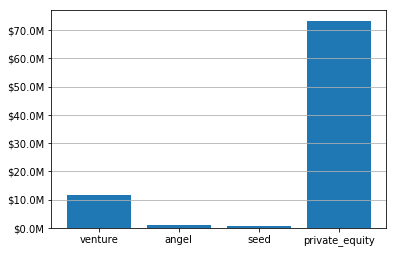

In [36]:
from matplotlib.ticker import FuncFormatter

# Function to format the value as millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)


formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
# horizontal line indicating the threshold
plt.bar(['venture', 'angel', 'seed', 'private_equity'], [venture, angel, seed, private_equity])
ax.grid(axis='y')

([<matplotlib.patches.Wedge at 0x113e05ba8>,
 [Text(1.00189,0.454103,'venture'),
  Text(0.695919,0.851878,'angel'),
  Text(0.642874,0.892588,'seed'),
  Text(-0.972452,-0.514137,'private_equity')],
 [Text(0.546487,0.247692,'13.5%'),
  Text(0.379592,0.464661,'1.1%'),
  Text(0.350659,0.486866,'0.8%'),
  Text(-0.530428,-0.280439,'84.5%')])

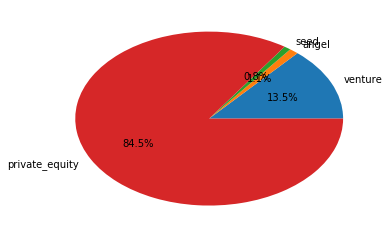

In [37]:
#fraction of investments
labels = ['venture', 'angel', 'seed', 'private_equity']
total = venture + angel + seed + private_equity

fractions = [venture * 100/ total, angel * 100/ total, seed * 100/ total, private_equity *100/ total]
plt.pie(fractions, labels=labels, autopct='%1.1f%%', shadow=False)



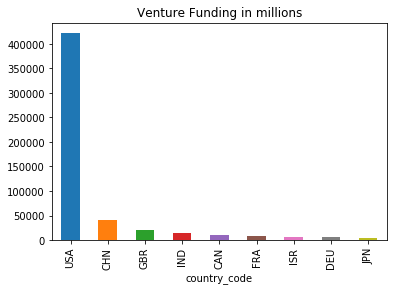

In [38]:

top_countries.apply(lambda row: row['raised_amount_usd'] / 1000000.0, axis=1).plot(kind='bar', title= 'Venture Funding in millions')

/Users/amirisev/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


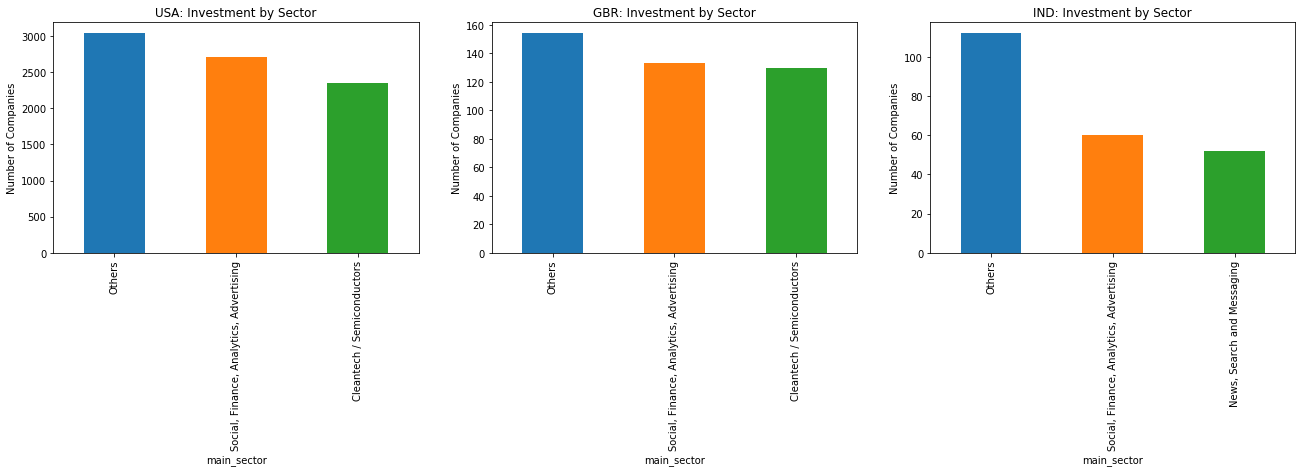

In [39]:
plt.subplot(133)
plt.subplot(131)
d1.groupby('main_sector')['count_by_sector'].count().nlargest(3).plot(kind='bar')
plt.title('USA: Investment by Sector')
plt.ylabel('Number of Companies')

plt.subplot(132)
d2.groupby('main_sector')['count_by_sector'].count().nlargest(3).plot(kind='bar')
plt.title('GBR: Investment by Sector')
plt.ylabel('Number of Companies')

plt.subplot(133)
d3.groupby('main_sector')['count_by_sector'].count().nlargest(3).plot(kind='bar')
plt.title('IND: Investment by Sector')
plt.ylabel('Number of Companies')

plt.subplots_adjust(bottom=0.1, right=3, top=0.9)